In [1]:
# %matplotlib widget
%matplotlib inline
# %matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import Pyro4.util

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Run experiment and analysis

In [4]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [5]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [8]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [9]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=1)

In [10]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [11]:
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

In [ ]:
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]

ch=1
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = soc.us2cycles(times_us, gen_ch=ch)
times_samps = samps_per_clk * times_cycles
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, fill_value='extrapolate')
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)

plt.plot(maxv*iamps)
plt.plot(maxv*qamps)

## Test 1Q tomo

In [ ]:
qubit = 0 # which qubit/resonator we want to probe

In [ ]:
tomo = meas.StateTomography1QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StateTomoQ{qubit}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps per state for singleshot calibration
    qubit=qubit,
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

## Qram experiment

In [213]:
meas_order = np.array(['Z', 'X', 'Y'])
# meas_order = np.array(['Z'])

In [214]:
save_data = False

In [215]:
qubit = 1 # which qubit/resonators to do tomo on
init_state = '|0>|0+1>' # switch, input
# init_state = '|test>'
# init_state = 'Q0Q1_|0>|0+1>'
# play_pulses = [2, 4] # [1, 3] # [2, 4] # [2, 1, 4, 3]
# play_pulses = [1, 3] # [1, 3] # [2, 4] # [2, 1, 4, 3]
play_pulses = [1]*16 # Q2/Q1
# play_pulses = [2, 1, 4, 3]
# play_pulses = [0]

# pi_half_swaps = None
pi_half_swaps = [True, False]

# cool_qubits = [0, 1]
cool_qubits = None
add_phase = True
readout_cool = False
use_IQ_pulse = False
use_robust_pulses = True # use robust pulses for state prep + tomo

full_mux_expt = True
resonator_reset = [0, 2, 3]

# The ZZ_qubit will change the frame of the tomography.
# I think it actually makes more sense to set ZZ_qubit=None always, set the ZZ_qubit to whatever in the evol mats,
# then it should simulate in the correct (bare) frame what is happening during the pulse...
# ZZ_qubit = 0
ZZ_qubit = None

print('play_pulses', play_pulses)

play_pulses [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [216]:
# saved_files = []
qramExpt = meas.QramProtocol1QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=15000, # number of reps per tomo/time step,
    # reps=20000, # number of reps per tomo/time step,
    # reps=2000000, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=10000, # reps per state for singleshot calibration
    # singleshot_reps=200, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    qubit=qubit,
    init_state=init_state,
    play_pulses=play_pulses,
    
    cool_qubits=cool_qubits,
    
    use_IQ_pulse=use_IQ_pulse, # state transfer IQ pulses for the state prep
    use_robust_pulses=use_robust_pulses, # use robust pulses for state prep + tomo
    plot_IQ=False,
    
    add_phase=add_phase,
    ZZ_qubit=ZZ_qubit,
    pi_half_swaps=pi_half_swaps,
    
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    
    # readout_cool=readout_cool,
    # n_init_readout=1,
    # n_trig=1,
    # # init_read_wait_us=5,
    # init_read_wait_us=10,
    
    
#     thresholds=[0, 435.2742847736969, 0, 0],
#     angles=[0, -71.14156770965094, 0, 0],
#     ge_avgs=[[0, 0, 0, 0], [-21.004029603255344, 340.8385202238047, 108.85149118006103, 532.2538750050865], [0, 0, 0, 0], [0, 0, 0, 0]] ,
#     counts_calib=[[17573.0, 2427.0], [3659.0, 16341.0]]
    
)

for q in range(4):
    if q != qubit:
        qramExpt.cfg.device.readout.gain[q] = 1e-4

# print(qramExpt.cfg)

try:
    qramExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 50.76000000000002 	 angle (deg): 0.0 	 threshold ge: 1175.4487332777078
thresholds=[0, 1175.4487332777078, 0, 0],
angles=[0, 0.0, 0, 0],
ge_avgs=[[0, 0, 0, 0], array([ 961.58912642,    0.        , 1378.48908367,    0.        ]), [0, 0, 0, 0], [0, 0, 0, 0]] ,
counts_calib=[[7613.0, 2387.0], [2550.0, 7450.0]]


  0%|          | 0/3 [00:00<?, ?it/s]

In [318]:
saved_files.append(qramExpt.save_data())

Saving S:\QRAM\qram_4QR2\data\data_241025\00003_QramProtocol1QTomo.h5


In [217]:
tomo = qramExpt

### Sweep pi/2 phases

In [462]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [463]:
qubit = 1

In [464]:
span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

saved_files = []
save_data = True

# start_phi = -10
# stop_phi = 10
# # n_phi = 30
# n_phi = 21

# phi_sweep = np.linspace(start_phi, stop_phi, n_phi)
# print('phi_sweep', phi_sweep)

# for phi in tqdm(phi_sweep):

center_freq = yaml_cfg.device.qubit.f_ge[qubit*4 + qubit]
span_freq = 0.5
n_freq = 21
freq_sweep = np.linspace(center_freq-span_freq/2, center_freq+span_freq/2, n_freq)
print('freq_sweep', freq_sweep)
for freq in tqdm(freq_sweep):
    
    qramExpt = meas.QramProtocol1QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=15000, # number of reps per tomo/time step,
        # reps=200, # number of reps per tomo/time step,
        # singleshot_reps=1, # reps per state for singleshot calibration
        singleshot_reps=15000, # reps per state for singleshot calibration
        # singleshot_reps=200, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        qubit=qubit,
        init_state=init_state,
        play_pulses=play_pulses,
        
        cool_qubits=cool_qubits,
        use_IQ_pulse=use_IQ_pulse,
        plot_IQ=False,
        
        meas_order=['Z'],
        
        add_phase=add_phase,
        ZZ_qubit=ZZ_qubit,
        pi_half_swaps=pi_half_swaps,
    )
    
    # qramExpt.cfg.device.qubit.pulses.pi_ge.half_correction_phase[qubit*4 + qubit] = phi
    qramExpt.cfg.device.qubit.f_ge[qubit*4 + qubit] = freq
    
    try:
        qramExpt.acquire(progress=False, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
    if save_data: saved_files.append(qramExpt.save_data())


freq_sweep [3448.12434469 3448.14934469 3448.17434469 3448.19934469 3448.22434469
 3448.24934469 3448.27434469 3448.29934469 3448.32434469 3448.34934469
 3448.37434469 3448.39934469 3448.42434469 3448.44934469 3448.47434469
 3448.49934469 3448.52434469 3448.54934469 3448.57434469 3448.59934469
 3448.62434469]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00139_QramProtocol1QTomo.h5


  5%|███▉                                                                               | 1/21 [00:23<07:42, 23.13s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00140_QramProtocol1QTomo.h5


 10%|███████▉                                                                           | 2/21 [00:45<07:15, 22.93s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00141_QramProtocol1QTomo.h5


 14%|███████████▊                                                                       | 3/21 [01:08<06:51, 22.86s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00142_QramProtocol1QTomo.h5


 19%|███████████████▊                                                                   | 4/21 [01:31<06:30, 22.94s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00143_QramProtocol1QTomo.h5


 24%|███████████████████▊                                                               | 5/21 [01:54<06:06, 22.90s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00144_QramProtocol1QTomo.h5


 29%|███████████████████████▋                                                           | 6/21 [02:17<05:42, 22.85s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00145_QramProtocol1QTomo.h5


 33%|███████████████████████████▋                                                       | 7/21 [02:40<05:21, 22.95s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00146_QramProtocol1QTomo.h5


 38%|███████████████████████████████▌                                                   | 8/21 [03:03<04:59, 23.04s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00147_QramProtocol1QTomo.h5


 43%|███████████████████████████████████▌                                               | 9/21 [03:26<04:36, 23.03s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00148_QramProtocol1QTomo.h5


 48%|███████████████████████████████████████                                           | 10/21 [03:49<04:12, 22.94s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00149_QramProtocol1QTomo.h5


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:12<03:48, 22.89s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00150_QramProtocol1QTomo.h5


 57%|██████████████████████████████████████████████▊                                   | 12/21 [04:35<03:26, 22.91s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00151_QramProtocol1QTomo.h5


 62%|██████████████████████████████████████████████████▊                               | 13/21 [04:57<03:02, 22.86s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00152_QramProtocol1QTomo.h5


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [05:21<02:40, 22.92s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [05:43<02:16, 22.82s/it]

Saving S:\QRAM\qram_4QR2\data\data_240617\00153_QramProtocol1QTomo.h5
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00154_QramProtocol1QTomo.h5


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:07<01:54, 23.00s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00155_QramProtocol1QTomo.h5


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [06:30<01:32, 23.03s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00156_QramProtocol1QTomo.h5


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [06:53<01:09, 23.01s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00157_QramProtocol1QTomo.h5


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [07:15<00:45, 22.95s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00158_QramProtocol1QTomo.h5


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [07:38<00:22, 22.89s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00159_QramProtocol1QTomo.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:01<00:00, 22.93s/it]


In [287]:
apply_ps = False

all_n_tomo = []
all_n_calib = []
all_Z_vals = []

for i, saved_file in enumerate(saved_files):
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    cfg = AttrDict(attrs['config'])
    assert np.all(np.array(attrs['calib_order']) == tomo_analysis.calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)
    n_tomo = tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)
    all_Z_vals.append(n_tomo[0][0])

plt.figure()
# plt.plot(phi_sweep, all_Z_vals, '.-')
# plt.xlabel('Phi Correction on all pi/2 gates (deg)')
plt.plot(freq_sweep, all_Z_vals, '.-')
plt.xlabel('Frequency')
plt.ylabel('Z basis 0 population')
plt.show()

NameError: name 'freq_sweep' is not defined

<Figure size 640x480 with 0 Axes>

## Run analysis

### Get the n_tomo

In [218]:
apply_ps = False
# ps_adjust = [-0.3, -1.0, -0.3, -0.3]
ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [219]:
data = tomo.data
cfg = tomo.cfg
init_state = tomo.cfg.expt.init_state
qubit = tomo.cfg.expt.qubit
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)

print('meas_order', meas_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data=data, cfg=cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, tomo_qubits=[qubit], apply_ps=apply_ps, verbose=True)

print('Tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
print('Confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=5))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

meas_order ['Z' 'X' 'Y']
Tomography counts
[[0.56086667 0.43913333]
 [0.70173333 0.29826667]
 [0.4958     0.5042    ]]
Confusion matrix counts
[[0.7613 0.2387]
 [0.255  0.745 ]]
Confusion matrix corrected tomo matrix will be
[[0.60412 0.39588]
 [0.88235 0.11765]
 [0.47561 0.52439]]


Plot single shot blobs for the X, Y measurements

In [301]:
q = qubit
# q = 0

data = tomo.data
check_states = []

data['iqshots'] = []
iprep_g = 0
iprep_e = 1
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')

ibasis_Z = 0
ibasis_X = 1
ibasis_Y = 2
data['iqshots'].append((data[f'ishots_raw'][ibasis_Z, :, -1, :], data[f'qshots_raw'][ibasis_Z, :, -1, :]))
check_states.append('Z')
data['iqshots'].append((data[f'ishots_raw'][ibasis_X, :, -1, :], data[f'qshots_raw'][ibasis_X, :, -1, :]))
check_states.append('X')
data['iqshots'].append((data[f'ishots_raw'][ibasis_Y, :, -1, :], data[f'qshots_raw'][ibasis_Y, :, -1, :]))
check_states.append('Y')

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g unrotated averages:
I -686.1838278229907 +/- 171.6904014401197 	 Q -1040.8107648524924 +/- 139.59855135027732 	 Amp 1256.057375733416 +/- 159.4381138564166
Rotated (theta=0.34376459128927966):
I -295.2485446389693 +/- 160.05618189343232 	 Q -1211.1827239055272 +/- 152.79845589357888 	 Amp 1246.6496275211578 +/- 159.4381138564166
e unrotated averages:
I -426.6805430484911 +/- 168.69650825170964 	 Q -1133.7072836046118 +/- 157.4768261089311 	 Amp 1223.3520752426134 +/- 154.969846652681
Rotated (theta=0.34376459128927966):
I -19.618869159317722 +/- 170.38111055401956 	 Q -1211.1827239055272 +/- 155.65262549677928 	 Amp 1211.3416077697912 +/- 154.969846652681
Z unrotated averages:
I -557.0547527127841 +/- 214.21474507947178 	 Q -1091.5471944727026 +/- 156.86971099325135 	 Amp 1243.7327408113179 +/- 159.40579648075965
Rotated (theta=0.34376459128927966):
I -156.57459100859165 +/- 215.27853069623347 	 Q -1215.4298304433792 +/- 155.40661973622665 	 Amp 1225.4734902400496 +/- 159.40579648075

[[0.6343500000000002], [-161.53050866445642], 19.696260226915427]

In [162]:
(498.72-287.84)/(808.256-287.84)

0.4052142901063766

### Reopen old data

In [457]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [461]:
saved_files = ['S:\QRAM\qram_4QR2\data\data_240617\\00123_QramProtocol1QTomo.h5']
data, attrs = prev_data(saved_files[-1], None)
cfg = AttrDict(attrs['config'])
pulse_dict = attrs['pulse_dict']

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)
print(cfg.device.qubit.pulses.pi_ge.half_correction_phase)

init_state = cfg.expt.init_state
qubit = cfg.expt.qubit
play_pulses = cfg.expt.play_pulses
cool_qubits = cfg.expt.cool_qubits
print('init state', init_state)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data=data, cfg=cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, tomo_qubits=[qubit], apply_ps=apply_ps, verbose=True)

print(tomo_analysis.calib_order)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

# print(f'thresholds={data["thresholds"].tolist()},')
# print(f'angles={data["angles"].tolist()},')
# print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
# print(f'counts_calib={data["counts_calib"].tolist()}')

S:\QRAM\qram_4QR2\data\data_240617\00123_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'qshots_raw', 'thresholds'])
[0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
init state |test>
['g' 'e']
Tomography counts
[[8219. 1781.]]
Confusion matrix counts
[[8462. 1538.]
 [2265. 7735.]]
Confusion matrix corrected tomo matrix will be
[[0.96078748 0.03921252]]


 C:\Users\slab\AppData\Local\Temp\ipykernel_20884\1939458940.py: 13

In [ ]:
# qubits = [qubit]
# for basis, pulse_cfgs in tqdm(pulse_dict.items()):
#     for pulse_name, pulse_cfg in pulse_cfgs.items():
#         if pulse_cfg['flag'] != 'ZZcorrection': continue
#         print(pulse_name, pulse_cfg)

### Generate test data

In [704]:
n_tomo_raw = tomo_analysis.generate_counts(rho_id=rho_id, n_tot=1000, noise=1, evol_mats=evol_mats)
n_calib = qt.qeye(2).full()
print(n_tomo)
print(n_calib)

Generating with evol mats
[[5.00000000e+02 5.00000000e+02]
 [1.00059973e+03 4.40934027e-01]
 [4.79585945e+02 5.20408617e+02]]
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


### Get rho_id

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [89]:
# psi_id = 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])
psi_id = (psiZ[0]+psiZ[1]).unit()
# psi_id = psiZ[1].unit()

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


### Run MLE without ZZ correction

Fidelity (no ZZ correction): 0.8823490821621728
Purity (no ZZ correction): 0.8152541561713598
[[0.604+0.j    0.382+0.024j]
 [0.382-0.024j 0.396-0.j   ]]


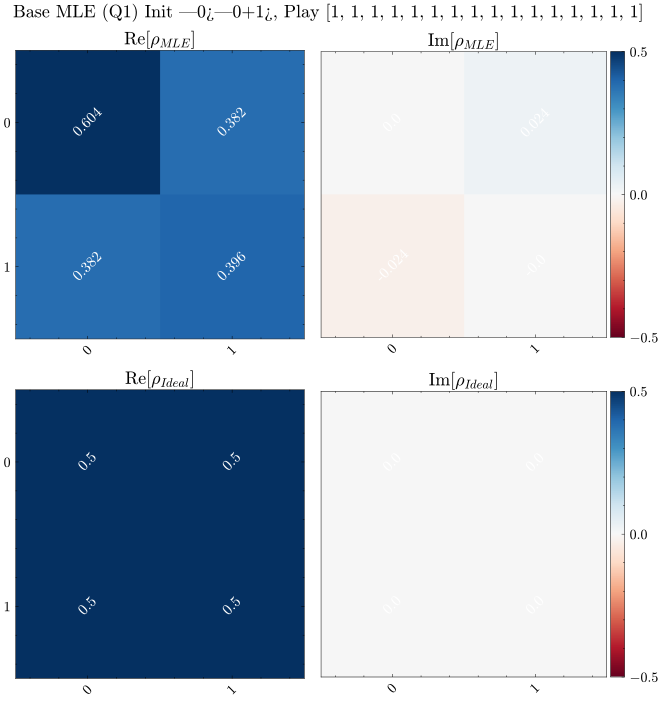

In [220]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
)

if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE, decimals=3))
savetitle=None
# savetitle=saved_files[-1][:-3]+f'_baseMLE_Q{qubit}.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit}) Init {init_state}, Play {play_pulses}', cmax=0.5, savetitle=savetitle)

# print('Saved svg:', savetitle)
# print('Saved data:')
# print(*saved_files)

### Run MLE with ZZ

#### Get evol mats for ZZ

In [66]:
# Recover old config
# yaml_cfg = AttrDict(attrs['config'])

In [66]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [67]:
# ZZ_qubit = None
tomo_qubits = [qubit]

In [68]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

# evol_mats_filename = None
evol_mats_filename = f"evol_mats_"
for q in tomo_qubits:
    evol_mats_filename += f"{q}"
if ZZ_qubit is not None:
    evol_mats_filename += f"_ZZ{ZZ_qubit}"
evol_mats_filename += ".npz"
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_1_ZZ0.npz


TOMO QUBITS [1]
HAMILTONIAN QUBITS [1 0]
qubit freqs [3448.3482722  4111.14452003]
alphas [-100.50018335 -225.83273154]
ZZs (MHz) [[ 0.         -5.36871697]
 [-5.36056122  0.        ]]
Will save to filename evol_mats_1_ZZ0.npz


  0%|          | 0/3 [00:00<?, ?it/s]

Z
init state ge
truncating to states inds [1, 5]
evolution ket result
[[1.+0.j]
 [0.+0.j]]
init state ee
truncating to states inds [1, 5]
evolution ket result
[[0.+0.j]
 [1.+0.j]]

X
Y_robust_ZZ0_half_q1
add (robust) pi/2 pulse on qubit 1 with freq 3442.9795552267146


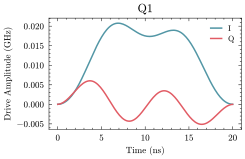

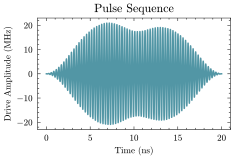

init state ge
truncating to states inds [1, 5]
evolution ket result
[[ 0.7016546 -0.0476728j ]
 [-0.58348909-0.40613865j]]
from ge
ge probabilty 0.4945913551439465
ee probabilty 0.5054075846829044
init state ee
truncating to states inds [1, 5]
evolution ket result
[[0.70962351-0.04736297j]
 [0.57646826+0.40233762j]]
from ee
ge probabilty 0.5058084550401216
ee probabilty 0.49419090134285754

Y
X_robust_ZZ0_half_q1
add (robust) pi/2 pulse on qubit 1 with freq 3442.9795552267146


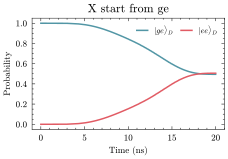

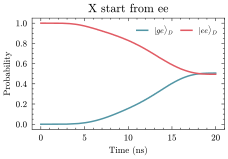

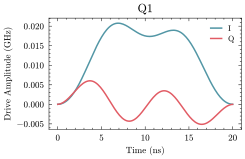

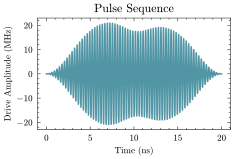

init state ge
truncating to states inds [1, 5]
evolution ket result
[[0.7016689 -0.04765298j]
 [0.40612749-0.58348128j]]
from ge
ge probabilty 0.49460953037323313
ee probabilty 0.5053894025602772
init state ee
truncating to states inds [1, 5]
evolution ket result
[[-0.04736261-0.70961079j]
 [ 0.57649343+0.40232404j]]
from ee
ge probabilty 0.5057903520554463
ee probabilty 0.49420897022504917

Saved evol mats to file S:\QRAM\qram_4QR2\evol_mats\evol_mats_1_ZZ0.npz


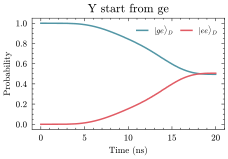

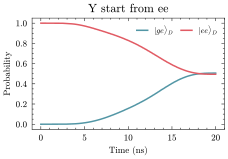

In [69]:
evol_mats = tomo_analysis.get_evol_mats_from_yaml(
    tomo_qubits=[qubit],
    yaml_cfg=yaml_cfg,
    pulse_dict=pulse_dict,
    ZZ_qubit=ZZ_qubit,
    cutoffs=[4]*(len(tomo_qubits) + (1 if ZZ_qubit is not None else 0)),
    soccfg=soc,
    debug=True,
    evol_mats_path=evol_mats_path,
    evol_mats_filename=evol_mats_filename,
)

#### Reload evol mats

In [70]:
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_1_ZZ0.npz


#### (Actually) run MLE with ZZ correction

 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1243ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 1248

[[ 0.466+0.j    -0.393+0.307j]
 [-0.393-0.307j  0.534+0.j   ]]
list format [[(0.466+0j), (-0.393+0.307j)], [(-0.393-0.307j), (0.534+0j)]]
Fidelity (with ZZ correction): 0.5339583791219211
Purity (with ZZ correction): 0.9999999999999999
Target purity: 1.0


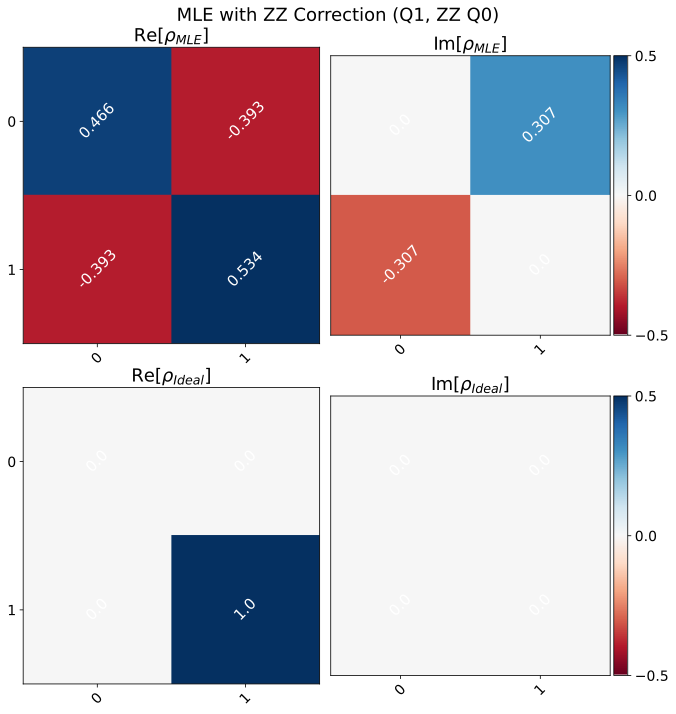

Saved svg: None
Saved data:


NameError: name 'saved_files' is not defined

In [71]:
rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
# savetitle=saved_files[-1][:-3]+'_ZZcorrect.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{qubit}' + (f', ZZ Q{ZZ_qubit}' if ZZ_qubit is not None else '') + ')', savetitle=savetitle, cmax=0.5)
print('Saved svg:', savetitle)

print('Saved data:')
print(*saved_files)

### Rotate density matrix

In [211]:
phis = [None]
phis[0] = np.linspace(0, 360, 360)
rho_MLE_rot, best_phis, best_fid, fids_grid = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('best phi', best_phis)
print('best fid', best_fid)

  0%|          | 0/360 [00:00<?, ?it/s]

Improved fidelity by (%) 7.5736069839201665
best phi [321.89415042]
best fid 0.8487649311921514


In [212]:
print(len(play_pulses))
print(2*(best_phis[0])/len(play_pulses))
print(2*(best_phis[0]-360)/len(play_pulses))

16
40.23676880222841
-4.763231197771589


Fidelity (after rotation): 0.9006387865410025
Purity (after rotation): 0.8210737253102929
Target purity: 0.9999999999999996
Best rotation: [115.32033426183844]


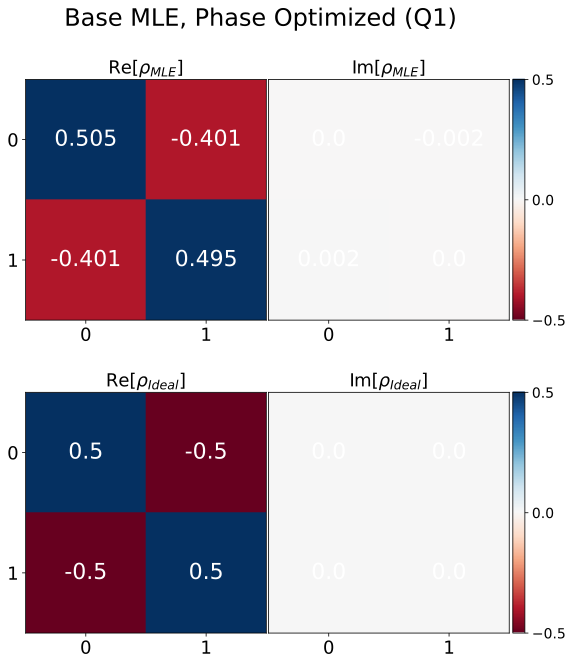

In [118]:
# best_phis = [161.37931034482762, 148.9655172413793, 211.03448275862073]
# best_phis = [310.3448275862069]
# best_phis = [90]
z_phi1 = z_gate_1q(*best_phis)
rho_MLE_rot = (z_phi1*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi1.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=savetitle, cmax=0.5)

# Loop over initial states

In [ ]:
save_data = True
init_state_sweep = ['|1>|1>', '|1>|0+1>', '|1>|0>', '|0>|1>', '|0>|0+1>', '|0>|0>']
qubit_sweep = [3, 3, 3, 2, 2, 2]


psi_id_plusj = (psiZ[0]+1j*psiZ[1]).unit()
psi_id_1 = (psiZ[1]).unit()
psi_id_0 = (psiZ[0]).unit()
psi_id_sweep = [psi_id_1, psi_id_plusj, psi_id_0, psi_id_1, psi_id_plusj, psi_id_0]

rho_id_sweep = [qt.ket2dm(psi_id) for psi_id in psi_id_sweep]

# play_pulses = [2, 4] # Q3/Q1
# play_pulses = [1, 3] # Q2/Q1
play_pulses = [2, 1, 4, 3]

meas_order = np.array(['Z', 'X', 'Y'])
# meas_order = ['Z']

num_repeat = 1

In [ ]:
saved_files = []

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


In [ ]:
qubit_prev = -1
for i_rep in range(num_repeat):
    for i_init, init_state in enumerate(init_state_sweep):
        if qubit_sweep[i_init] != qubit_prev:
            thresholds = None
            angles = None
            ge_avgs = None
            counts_calib = None
        qubit_prev = qubit_sweep[i_init]
        print(init_state)
        tomo = meas.QramProtocol1QTomoExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
        tomo.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
            reps=30000, # number of reps per tomo/time step,
            singleshot_reps=30000, # reps per state for singleshot calibration
            qubit=qubit_sweep[i_init],
            init_state=init_state,
            play_pulses=play_pulses,
            thresholds=thresholds,
            angles=angles,
            ge_avgs=ge_avgs,
            counts_calib=counts_calib,
        )
        try:
            tomo.go(analyze=False, display=False, progress=False, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        if save_data: saved_files.append(tomo.save_data())
        data = tomo.data
        if thresholds is None:
            thresholds = data['thresholds']
            angles = data['angles']
            ge_avgs = data['ge_avgs']
            counts_calib = data['counts_calib']
        print()

In [ ]:
print(init_state_sweep)
print(saved_files[0])
print('...')
print(saved_files[-1])

Reconstruct saved_files array

In [ ]:
saved_files = []
start_ind = 0
file_name = '_QramProtocol1QTomo'


# for i in range(len(gain_sweep)*num_repeat):
for i in range(1725, 1730+1):
    ind = i+start_ind
    if ind < 10:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\0000{ind}{file_name}.h5')
    elif ind < 100:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\000{ind}{file_name}.h5')
    elif ind < 1000:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\00{ind}{file_name}.h5')
    elif ind < 10000:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\0{ind}{file_name}.h5')
print(saved_files)

### Calculate fidelities

Full density matrix fidelities with MLE with phase optimization

In [246]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_opt_phis = []
all_fids_rot = []

for i, saved_file in enumerate(saved_files):
    init_state = init_state_sweep[i]
    print('init_state', init_state)
    rho_id = rho_id_sweep[i]
    qubit = qubit_sweep[i]
    
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    cfg = AttrDict(attrs['config'])
    assert np.all(np.array(attrs['meas_order']) == meas_order)
    assert np.all(np.array(attrs['calib_order']) == calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=opt_phis)
    all_fids_rot.append(fid_rot)
    all_opt_phis.append(best_phis)
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)

In [ ]:
print('init states', init_state_sweep)
print('fids', all_fids)
print('opt phis', all_opt_phis)
print('fids_rot', all_fids_rot)

# Loop over 2Q sweep parameters

In [60]:
save_data = True
cool_qubits = None

# # Q3/Q1 sweep
# gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
# opt_lens=[0.47200285304219325, 0.4462483335766198, 0.3935770171685791, 0.3445003248172285, 0.3392260760342203, 0.3197021004429004, 0.2961380879096939, 0.2805061186736545, 0.2636938615611933, 0.25335798809866994, 0.237356076571024, 0.22966955817886023, 0.21757555901250342, 0.21082829572908218, 0.19942680930794082, 0.19304159020342734, 0.18530539250720215, 0.17853124431578662, 0.16243437135173172, 0.16758423597388725, 0.16388394269244386, 0.1583632755769038, 0.1552121470900272, 0.1504628462909928, 0.14532062321917064, 0.14367011071809124, 0.1401874263524681, 0.13800939138023388, 0.13499047922088145, 0.13176217034566462, 0.13116632738422024, 0.12663711487670318, 0.12529014926169998, 0.1227017779371818, 0.11959440453657395]
# opt_freqs=[5147.99318202018, 5147.6827919025, 5147.369818306699, 5147.0095936948965, 5146.649493923319, 5146.2282856729535, 5145.807622120507, 5145.343359864123, 5144.89514907717, 5144.340271588578, 5143.829123776181, 5143.212857950753, 5142.648323761926, 5142.032496978786, 5141.42603268382, 5140.74136130339, 5140.050826982874, 5139.240261999657, 5138.36554460062, 5137.619711613276, 5136.819259335623, 5136.308146400125, 5135.096981377383, 5134.31522456792, 5133.696066602609, 5132.2795445243155, 5131.764052253434, 5130.860289965018, 5129.585923132024, 5128.905555535576, 5127.702625251956, 5126.33057464852, 5124.876083467402, 5123.65698890857, 5123.077273756315]

# # Q2/Q1 sweep
# gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
# opt_lens=[0.7483775522510219, 0.6810580910473285, 0.6232488874237956, 0.5710811563305859, 0.5336321373105744, 0.502477763400806, 0.46827546441539536, 0.44193131519875684, 0.4192130834099241, 0.39319056406800096, 0.37979579309938755, 0.3621777716832878, 0.35354293858873814, 0.33682379587539135, 0.32147346568431867, 0.3145046495873327, 0.30616661142363955, 0.2953218350964056, 0.28722930240555794, 0.2766293763842703, 0.27193328273050726, 0.26636580698161355, 0.2615788689124485, 0.25544388051556954, 0.2513829023888658, 0.2482639260947562, 0.24195126335430306, 0.23941970191389847, 0.23596914189911483, 0.23419778982563877, 0.23487397113550215, 0.22671506108674308, 0.2265472992033885, 0.2231754286391354, 0.22381249781504373]
# opt_freqs=[5886.902822953964, 5886.754089017005, 5886.589402755899, 5886.416056171995, 5886.224764171905, 5886.019080915752, 5885.808738920236, 5885.585546008087, 5885.346520098976, 5885.109291119816, 5884.837917049513, 5884.57419755289, 5884.29812359889, 5884.017408547941, 5883.771504855529, 5883.450186203751, 5883.164664527816, 5882.872121678602, 5882.5805042052525, 5882.301417346907, 5881.995219708142, 5881.719092371096, 5881.407520434077, 5881.117006614939, 5880.835595481339, 5880.533920726679, 5880.243370036971, 5879.930616524965, 5879.62410518735, 5879.276838436835, 5878.961950563587, 5878.665728998478, 5878.348229475893, 5878.064804949598, 5877.762643213729]
gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
opt_lens=[0.3652665248607346, 0.3364360408225085, 0.3090058873878607, 0.2855004938962573, 0.2672691556131814, 0.25383566510212496, 0.23787942646413512, 0.22269683236648835, 0.20810080362067013, 0.1980140479194843, 0.1879207763604532, 0.17914273736578457, 0.17318071703198124, 0.165302491414096, 0.15645314132873583, 0.14999643042085448, 0.14235694191527695, 0.13789524647760568, 0.13449092339426208, 0.12786865230023503, 0.12461366597186566, 0.12108638951979868, 0.11749609546920893, 0.11660569951449595, 0.11205517943496829, 0.10871101653727386, 0.11265991183688683, 0.11033101854221244, 0.10255623459159191, 0.10287942373647137, 0.1024213466719276, 0.09990037874848043, 0.09704919363646712, 0.09615345836239059, 0.09526904166835203]
opt_freqs=[5886.871998520562, 5886.680583238236, 5886.607072387078, 5886.406577403408, 5886.235820807416, 5886.041724599334, 5885.803345990381, 5885.60555708211, 5885.383368010164, 5885.175516192442, 5884.946496175722, 5884.694545141329, 5884.472817014968, 5884.224699414351, 5884.001268608925, 5883.76850246323, 5883.53168232843, 5883.322171975439, 5883.081340342817, 5882.837641716799, 5882.622566790709, 5882.393152883211, 5882.170670269309, 5881.907563714976, 5881.712312699388, 5881.5428669642515, 5881.18207805125, 5880.955144224998, 5880.854010417532, 5880.5686222113645, 5880.342062762142, 5880.103968841256, 5879.948870216819, 5879.741977840243, 5879.513687020447]

# gain_sweep = [gain_sweep[0], gain_sweep[15], gain_sweep[-1]]
# opt_lens = [opt_lens[0], opt_lens[15], opt_lens[-1]]
# opt_freqs = [opt_freqs[0], opt_freqs[15], opt_freqs[-1]]

# npts = 5
# gain_sweep = [12291]*npts
# opt_lens = [0.423]*npts
# # opt_lens = np.linspace(0, 2*423, npts)
# opt_freqs = [5884.144166666667]*npts
# opt_freqs = np.linspace(5885.04+300, 5885.041666666667)

# gain_sweep = [22708]*npts
# opt_lens = [0.3178934468718401]*npts
# # opt_lens = np.linspace(0, 2*423, npts)
# opt_freqs = [5144.32]*npts
# # opt_freqs = np.linspace(5885.04+300, 5885.041666666667)

sweep2Q_q = 2
qubit = 2 # 1q tomo measurement qubit

# sweep2Q_q = 3
# qubit = 3 # 1q tomo measurement qubit


# PLAY FORBIDDEN PULSES
psi_id = psiZ[0]
rho_id = qt.ket2dm(psi_id)

if sweep2Q_q == 2:
    # Q2/Q1 calibration (measure qubit=2)
    # init_state = '|0>|1>' # Q2/Q1 init state
    init_state = '|1>|1>' # Q3/Q1 init state
    play_pulses = [1, 3] # Q2/Q1 swap
elif sweep2Q_q == 3:
    # Q3/Q1 calibration (measure qubit=3)
    init_state = '|0>|1>' # Q2/Q1 init state
    # init_state = '|1>|1>' # Q3/Q1 init state
    play_pulses = [2, 4] # Q3/Q1 swap


# psi_id = (psiZ[0]+psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
# init_state = '|0+1>|1>'
# # play_pulses = [2, 4] # Q3/Q1
# play_pulses = [1, 3] # Q2/Q1

# Check heating
# init_state = '|0>|0>'

# play_pulses = [0]

# meas_order = None
meas_order = ['Z']

num_repeat = 10

full_mux_expt = True
resonator_reset = [0, 2, 3]


print('test_pi_half', test_pi_half)
print('gain_sweep', np.array(gain_sweep).tolist())
print('opt_lens', np.array(opt_lens).tolist())
print('opt_freqs', np.array(opt_freqs).tolist())
print('save data', save_data)
print('sweep2Q_q', sweep2Q_q, 'measure qubit', qubit)
print('init state', init_state)
print('play pulses', play_pulses)


test_pi_half True
gain_sweep [7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
opt_lens [0.3652665248607346, 0.3364360408225085, 0.3090058873878607, 0.2855004938962573, 0.2672691556131814, 0.25383566510212496, 0.23787942646413512, 0.22269683236648835, 0.20810080362067013, 0.1980140479194843, 0.1879207763604532, 0.17914273736578457, 0.17318071703198124, 0.165302491414096, 0.15645314132873583, 

In [61]:
opt_phis = [None]
thresholds = None
angles = None
ge_avgs = None
counts_calib = None

In [62]:
count = 0

expt_sweep = Experiment(
    path=expt_path,
    prefix=f"eggf_1qtomo_sweepQ{sweep2Q_q}_tomoQ{qubit}",
    config_file=config_path,
)
expt_sweep.data = dict(gain_sweep=[], len_sweep=[], freq_sweep=[])

# saved_file = 'S:\QRAM\qram_4QR2\data\data_241025\\00001_eggf_1qtomo_sweepQ3_tomoQ3.h5'
# data, attrs = prev_data(expt_path=saved_file)
# cfg = AttrDict(attrs['config'])
# expt_sweep.data = data
# for key in expt_sweep.data.keys():
#     if key != 'num_repeat':
#         expt_sweep.data[key] = expt_sweep.data[key].tolist()

for i_rep in range(num_repeat):
    # if i_rep < 4: continue
    thresholds = None
    angles = None
    ge_avgs = None
    counts_calib = None
    for i_gain, gain in enumerate(tqdm(gain_sweep)):
        tomo = meas.QramProtocol1QTomoExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
            prefix=f"QramProtocol_EgGfsweepQ{sweep2Q_q}_1QTomoQ{qubit}",
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
        tomo.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
            reps=10000, # number of reps per tomo/time step,
            singleshot_reps=10000, # reps per state for singleshot calibration
            post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
            qubit=qubit,
            init_state=init_state,
            play_pulses=play_pulses,
            meas_order=meas_order,
            thresholds=thresholds,
            angles=angles,
            ge_avgs=ge_avgs,
            counts_calib=counts_calib,
            cool_qubits=cool_qubits,
            full_mux_expt=full_mux_expt,
            resonator_reset=resonator_reset,
        )

        if i_rep == 0 and i_gain == 0:
            expt_sweep.cfg = tomo.cfg
            expt_sweep.data['num_repeat'] = 0
        
        # tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        # tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
        # tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
        
        tomo.cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[sweep2Q_q] = int(gain)
        tomo.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[sweep2Q_q] = opt_lens[i_gain]
        tomo.cfg.device.qubit.f_EgGf_Q_half[sweep2Q_q] = opt_freqs[i_gain]
        
        # print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
        #       'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
        #       'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
        
        try:
            tomo.acquire(debug=False, progress=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        expt_sweep.data['gain_sweep'].append(int(gain))
        expt_sweep.data['freq_sweep'].append(opt_freqs[i_gain])
        expt_sweep.data['len_sweep'].append(opt_lens[i_gain])
        for data_key in tomo.data.keys():
            if data_key not in expt_sweep.data.keys():
                expt_sweep.data[data_key] = []
            # if i_rep == 0 and i_gain == 0: print('updated saved data', data_key)
            expt_sweep.data[data_key].append(tomo.data[data_key])
        
        # if save_data: saved_files.append(tomo.save_data())
            
        data = tomo.data
        if thresholds is None:
            thresholds = data['thresholds']
            angles = data['angles']
            ge_avgs = data['ge_avgs']
            counts_calib = data['counts_calib']
    expt_sweep.data['num_repeat'] += 1
    if save_data: expt_sweep.save_data()

  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:22, 14.78s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.09s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.27s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.42s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.95s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.67s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.49s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:25,  5.37s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.29s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.23s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:06<02:05,  5.25s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:11<01:59,  5.20s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.17s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.16s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.14s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.13s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.12s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:27,  5.13s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.12s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:52<01:16,  5.12s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:57<01:11,  5.13s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.13s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.13s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.13s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.13s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:46,  5.15s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:28<00:41,  5.14s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:33<00:35,  5.13s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:38<00:30,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:43<00:25,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.11s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.11s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.10s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:21, 14.75s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.08s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:25<03:53,  7.30s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:19,  6.44s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.96s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.68s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.50s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:25,  5.37s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.29s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:11,  5.24s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:11<01:59,  5.18s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.17s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.18s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:43,  5.18s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:38,  5.17s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.15s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:42<01:27,  5.14s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:47<01:22,  5.15s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:52<01:17,  5.15s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:57<01:11,  5.14s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.14s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.14s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.13s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:18<00:51,  5.14s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:23<00:46,  5.14s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:28<00:41,  5.13s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:33<00:35,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:38<00:30,  5.11s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:43<00:25,  5.15s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.14s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.14s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:59<00:10,  5.14s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:04<00:05,  5.13s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:22, 14.78s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<05:00,  9.09s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:25<03:53,  7.29s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:19,  6.44s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.96s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.67s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.48s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:25,  5.37s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.31s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:11,  5.24s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:11<01:58,  5.17s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.15s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.14s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.13s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.12s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.11s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.11s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:52<01:16,  5.13s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:57<01:11,  5.13s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.12s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.12s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.11s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.11s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:45,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.10s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:43<00:25,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.10s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.10s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.09s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:21, 14.74s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.07s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.25s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.41s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.94s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.66s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.48s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:25,  5.40s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:18,  5.31s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:11,  5.24s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:11<01:58,  5.17s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.15s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:47,  5.13s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.13s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.12s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.11s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.11s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.11s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.11s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:50,  5.10s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:45,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.09s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:42<00:25,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:47<00:20,  5.11s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.11s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.10s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:24, 14.84s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<05:00,  9.12s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:25<03:53,  7.28s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:19,  6.43s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.95s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.67s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.48s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:24,  5.36s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.28s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.23s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.18s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:10<01:58,  5.16s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.14s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:47,  5.13s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.12s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.11s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:31,  5.11s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.11s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.10s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.10s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.10s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:01<01:06,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.11s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:46,  5.14s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:41,  5.13s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.13s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:42<00:25,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.11s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.11s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.11s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.11s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:21, 14.75s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.07s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.26s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.41s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.94s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.66s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.48s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:24,  5.36s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.28s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.23s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:10<01:58,  5.16s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.14s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:47,  5.13s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.12s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:31,  5.11s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.10s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.10s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.10s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.10s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:01<01:06,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:06<01:01,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.10s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:46,  5.12s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.12s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:42<00:25,  5.11s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:47<00:20,  5.11s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.10s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.12s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:20, 14.73s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.07s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.26s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.41s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.94s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:43,  5.65s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.47s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:24,  5.35s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.27s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.22s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:05,  5.22s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:10<01:59,  5.19s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.16s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.15s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.13s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.12s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.11s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.11s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.12s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.11s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.10s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:45,  5.11s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.10s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:42<00:25,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:47<00:20,  5.10s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.10s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.10s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:20, 14.73s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.07s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.26s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.41s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.94s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.66s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.48s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:24,  5.36s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.28s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.23s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:10<01:59,  5.17s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.15s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.15s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.13s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.12s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.12s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.11s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.12s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.12s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.11s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.11s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.10s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:45,  5.11s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.11s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.13s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:43<00:25,  5.16s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.15s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.14s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.13s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.12s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:22, 14.79s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<05:00,  9.10s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:25<03:52,  7.28s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:19,  6.43s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.95s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:44,  5.67s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.49s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:25,  5.37s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:17,  5.29s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:10,  5.24s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:11<01:58,  5.17s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.16s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:48,  5.15s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.14s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.13s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.13s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:27,  5.13s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.12s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:52<01:16,  5.13s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:57<01:11,  5.12s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.12s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.12s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.13s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:51,  5.14s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:46,  5.13s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:41,  5.13s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:33<00:35,  5.13s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:38<00:30,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:43<00:25,  5.12s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:48<00:20,  5.12s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.12s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.11s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.11s/it]

Playing 0.09515224358974358us on q2q1


  0%|                                                                                           | 0/35 [00:00<?, ?it/s]

Playing 0.3655849358974359us on q2q1


  3%|██▎                                                                                | 1/35 [00:14<08:21, 14.74s/it]

Playing 0.335536858974359us on q2q1


  6%|████▋                                                                              | 2/35 [00:19<04:59,  9.09s/it]

Playing 0.30799278846153844us on q2q1


  9%|███████                                                                            | 3/35 [00:24<03:52,  7.27s/it]

Playing 0.2854567307692308us on q2q1


 11%|█████████▍                                                                         | 4/35 [00:30<03:18,  6.41s/it]

Playing 0.2679286858974359us on q2q1


 14%|███████████▊                                                                       | 5/35 [00:35<02:58,  5.94s/it]

Playing 0.2529046474358974us on q2q1


 17%|██████████████▏                                                                    | 6/35 [00:40<02:43,  5.65s/it]

Playing 0.23788060897435898us on q2q1


 20%|████████████████▌                                                                  | 7/35 [00:45<02:33,  5.47s/it]

Playing 0.2228565705128205us on q2q1


 23%|██████████████████▉                                                                | 8/35 [00:50<02:24,  5.35s/it]

Playing 0.20783253205128205us on q2q1


 26%|█████████████████████▎                                                             | 9/35 [00:55<02:18,  5.31s/it]

Playing 0.19781650641025642us on q2q1


 29%|███████████████████████▍                                                          | 10/35 [01:00<02:11,  5.25s/it]

Playing 0.18780048076923075us on q2q1


 31%|█████████████████████████▊                                                        | 11/35 [01:05<02:04,  5.20s/it]

Playing 0.18028846153846154us on q2q1


 34%|████████████████████████████                                                      | 12/35 [01:10<01:58,  5.17s/it]

Playing 0.1727764423076923us on q2q1


 37%|██████████████████████████████▍                                                   | 13/35 [01:16<01:53,  5.15s/it]

Playing 0.16526442307692307us on q2q1


 40%|████████████████████████████████▊                                                 | 14/35 [01:21<01:47,  5.13s/it]

Playing 0.15524839743589744us on q2q1


 43%|███████████████████████████████████▏                                              | 15/35 [01:26<01:42,  5.12s/it]

Playing 0.1502403846153846us on q2q1


 46%|█████████████████████████████████████▍                                            | 16/35 [01:31<01:37,  5.12s/it]

Playing 0.1427283653846154us on q2q1


 49%|███████████████████████████████████████▊                                          | 17/35 [01:36<01:32,  5.11s/it]

Playing 0.13772035256410256us on q2q1


 51%|██████████████████████████████████████████▏                                       | 18/35 [01:41<01:26,  5.11s/it]

Playing 0.13521634615384615us on q2q1


 54%|████████████████████████████████████████████▌                                     | 19/35 [01:46<01:21,  5.11s/it]

Playing 0.12770432692307693us on q2q1


 57%|██████████████████████████████████████████████▊                                   | 20/35 [01:51<01:16,  5.11s/it]

Playing 0.1252003205128205us on q2q1


 60%|█████████████████████████████████████████████████▏                                | 21/35 [01:56<01:11,  5.10s/it]

Playing 0.12019230769230768us on q2q1


 63%|███████████████████████████████████████████████████▌                              | 22/35 [02:02<01:06,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 66%|█████████████████████████████████████████████████████▉                            | 23/35 [02:07<01:01,  5.10s/it]

Playing 0.11768830128205128us on q2q1


 69%|████████████████████████████████████████████████████████▏                         | 24/35 [02:12<00:56,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 71%|██████████████████████████████████████████████████████████▌                       | 25/35 [02:17<00:50,  5.10s/it]

Playing 0.10767227564102563us on q2q1


 74%|████████████████████████████████████████████████████████████▉                     | 26/35 [02:22<00:45,  5.10s/it]

Playing 0.11268028846153846us on q2q1


 77%|███████████████████████████████████████████████████████████████▎                  | 27/35 [02:27<00:40,  5.10s/it]

Playing 0.11017628205128205us on q2q1


 80%|█████████████████████████████████████████████████████████████████▌                | 28/35 [02:32<00:35,  5.11s/it]

Playing 0.10266426282051282us on q2q1


 83%|███████████████████████████████████████████████████████████████████▉              | 29/35 [02:37<00:30,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 86%|██████████████████████████████████████████████████████████████████████▎           | 30/35 [02:42<00:25,  5.10s/it]

Playing 0.10266426282051282us on q2q1


 89%|████████████████████████████████████████████████████████████████████████▋         | 31/35 [02:47<00:20,  5.10s/it]

Playing 0.1001602564102564us on q2q1


 91%|██████████████████████████████████████████████████████████████████████████▉       | 32/35 [02:53<00:15,  5.10s/it]

Playing 0.09765625us on q2q1


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 33/35 [02:58<00:10,  5.10s/it]

Playing 0.09515224358974358us on q2q1


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 34/35 [03:03<00:05,  5.10s/it]

Playing 0.09515224358974358us on q2q1


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [03:08<00:00,  5.38s/it]


In [69]:
saved_file = expt_sweep.save_data()
data = expt_sweep.data
cfg = expt_sweep.cfg

In [70]:
print(saved_file)

S:\QRAM\qram_4QR2\data\data_241025\00011_eggf_1qtomo_sweepQ2_tomoQ2.h5


Replot data above

Reopen data

In [17]:
saved_file = 'S:\QRAM\qram_4QR2\data\data_241025\\00004_eggf_1qtomo_sweepQ3_tomoQ3.h5'
data, attrs = prev_data(expt_path=saved_file)
cfg = AttrDict(attrs['config'])

S:\QRAM\qram_4QR2\data\data_241025\00004_eggf_1qtomo_sweepQ3_tomoQ3.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_30584\1939458940.py: 13

Extracted data and attrs ['config']


### Calculate fidelities

In [26]:
apply_ps = False
# ps_adjust = [-0.3, -1.0, -0.3, -0.3]
ps_adjust = [0]*4
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

Full density matrix fidelities with MLE with phase optimization /next cell should be skipped

In [40]:
data.keys()

dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'freq_sweep', 'gain_sweep', 'ge_avgs', 'ishots_raw', 'len_sweep', 'num_repeat', 'qshots_raw', 'thresholds'])

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

data = expt_sweep.data
cfg = expt_sweep.cfg

for iexpt in range(len(data['gain_sweep'])):
    assert np.all(np.array(data['meas_order'][iexpt]) == meas_order)
    assert np.all(np.array(data['calib_order'][iexpt]) == calib_order)
    # pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )

    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    # tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=opt_phis)
    all_fids_rot.append(fid_rot)
    # tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)

Just the Z measurement fidelities

In [64]:
# sweep2Q_q = 3

all_epop = []

# print(cfg)
# print(data['num_repeat'])
ngains = len(data['len_sweep']) // data['num_repeat']
opt_lens = np.reshape(data['len_sweep'], (data['num_repeat'], ngains))[0]
opt_freqs = np.reshape(data['freq_sweep'], (data['num_repeat'], ngains))[0]
gain_sweep = np.reshape(data['gain_sweep'], (data['num_repeat'], ngains))[0]

print(opt_lens.shape)
print(gain_sweep)
print(np.array(data['counts_tomo']).shape)

finished_lens = False

# assert np.array(attrs['meas_order'][0] == 'Z')
# assert np.all(np.array(attrs['calib_order']) == calib_order)
# pulse_dict = attrs['pulse_dict']
n_tomo_raw_gains, n_calib_gains = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)
for iexpt in range(len(data['gain_sweep'])):
    n_tomo_raw = n_tomo_raw_gains[iexpt]
    n_calib = n_calib_gains[iexpt]
    # print(n_tomo_raw)
    # print(n_calib)

    n=tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)[0] # get Z measurement basis row
    epop = n[1]/sum(n)
    all_epop.append(epop)
all_epop = np.array(all_epop)
print(opt_lens)
print(opt_freqs)
print(gain_sweep)
print(100*all_epop)

(35,)
[ 7000  7735  8470  9205  9941 10676 11411 12147 12882 13617 14352 15088
 15823 16558 17294 18029 18764 19500 20235 20970 21705 22441 23176 23911
 24647 25382 26117 26852 27588 28323 29058 29794 30529 31264 32000]
(350, 1, 2)
[0.36526652 0.33643604 0.30900589 0.28550049 0.26726916 0.25383567
 0.23787943 0.22269683 0.2081008  0.19801405 0.18792078 0.17914274
 0.17318072 0.16530249 0.15645314 0.14999643 0.14235694 0.13789525
 0.13449092 0.12786865 0.12461367 0.12108639 0.1174961  0.1166057
 0.11205518 0.10871102 0.11265991 0.11033102 0.10255623 0.10287942
 0.10242135 0.09990038 0.09704919 0.09615346 0.09526904]
[5886.87199852 5886.68058324 5886.60707239 5886.4065774  5886.23582081
 5886.0417246  5885.80334599 5885.60555708 5885.38336801 5885.17551619
 5884.94649618 5884.69454514 5884.47281701 5884.22469941 5884.00126861
 5883.76850246 5883.53168233 5883.32217198 5883.08134034 5882.83764172
 5882.62256679 5882.39315288 5882.17067027 5881.90756371 5881.7123127
 5881.54286696 5881.182

best vals:
gain: pi_EgGf_Q.gain[2] = 12147
len: pi_EgGf_Q.sigma[2] = 0.22269683236648835
freq: f_EgGf_Q[2] = 5885.60555708211
best population (%): 6.15547965293573
From saved files:
S:\QRAM\qram_4QR2\data\data_241025\00011_eggf_1qtomo_sweepQ2_tomoQ2.h5


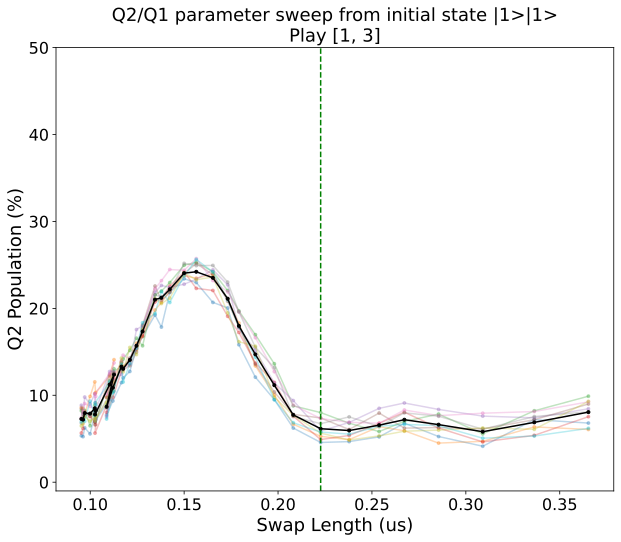

In [73]:
# plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')
# plt.plot(opt_lens, all_epop, label=f'Q{qubit} e', marker='.')
saveplot = False
# plot_filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\QramProtocol_EgGfsweepQ2_1QTomoQ2.svg'
# plot_filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\QramProtocol_EgGfsweepQ3_1QTomoQ3.svg'
# if saveplot: plt.style.use('dark_background')
# else: plt.style.use('default')
plt.style.use('default')

plt.figure(figsize=(10, 8))
# if saveplot: plt.axhline(50, color='w', linestyle='-', linewidth=0.3)
# else: plt.axhline(50, color='k', linestyle='-', linewidth=0.3)
# plt.grid(linewidth=0.1)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(opt_lens), len(opt_lens)))
for i_rep in range(data['num_repeat']):
    plt.plot(opt_lens, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)
average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(opt_lens, 100*average_epop, 'w', marker='.')
else: plt.plot(opt_lens, 100*average_epop, 'k', marker='.')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# best_ind = np.argmin(np.abs(average_epop-50))
best_ind = np.argmin(np.abs(average_epop - 0))
# best_ind = np.argmax(np.abs(average_epop - 0))
best_ind = 7
best_len = opt_lens[best_ind]
best_freq = opt_freqs[best_ind]
best_gain = gain_sweep[best_ind]
print('best vals:')
print(f'gain: pi_EgGf_Q.gain[{sweep2Q_q}] = {best_gain}')
print(f'len: pi_EgGf_Q.sigma[{sweep2Q_q}] = {best_len}')
print(f'freq: f_EgGf_Q[{sweep2Q_q}] = {best_freq}')
print(f'best population (%): {100*average_epop[best_ind]}')

# plot_qubit = AttrDict(attrs['config']).expt.qubit
plot_qubit = sweep2Q_q
if not saveplot: plt.axvline(best_len, color='g', linestyle='--')
plt.xlabel(f'Swap Length (us)', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}\nPlay {play_pulses}', fontsize=18)
# plt.ylim(40, 60)
plt.ylim(-1, 50)
# plt.ylim(80, 101)
# plt.legend()

if saveplot:
    plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
    print('Saved', plot_filename)
    # data['e_pop_avg'] = average_epop
    # np.savez(data_path + 'q1q2.npz', **data)

print('From saved files:')
print(saved_file)

plt.show()

Use for when actually did a gain sweep with fixed other parameters:

In [ ]:
# gain_sweep = np.linspace(0, 12208, 5)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(gain_sweep), len(gain_sweep)))

plt.figure(figsize=(8, 6))
for i_rep in range(num_repeat):
    plt.plot(gain_sweep, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)

average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(gain_sweep, 100*average_epop, 'w', marker='.')
else: plt.plot(gain_sweep, 100*average_epop, 'k', marker='.')
plt.xlabel('Gain', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 sweep, init {init_state}, fixed freq, len', fontsize=18)
# plt.ylim(40, 60)
plt.ylim(-1, 10)

print('From saved files:')
print(saved_files[0])
print('...')
print(saved_files[-1])
print('end population', 100*average_epop[-1] - 100*average_epop[0])

plt.show()

Use for when actually did a freq sweep with fixed other parameters:

In [ ]:
# freq_sweep = np.linspace(0, 12208, 5)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(opt_freqs), len(opt_freqs)))

plt.figure(figsize=(8, 6))
for i_rep in range(num_repeat):
    plt.plot(opt_freqs, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)

average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(opt_freqs, 100*average_epop, 'w', marker='.')
else: plt.plot(opt_freqs, 100*average_epop, 'k', marker='.')
plt.xlabel('Frequencies', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 sweep, init {init_state}, fixed freq, len', fontsize=18)
# plt.ylim(40, 60)
# plt.ylim(-1, 20)

print('From saved files:')
print(saved_files[0])
print('...')
print(saved_files[-1])
print('end population', 100*average_epop[-1] - 100*average_epop[0])

plt.show()

# Repeat over time

In [246]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
import time

start_time = time.time()

all_n_tomo = []
all_n_calib = []
all_fids = []
times = []

psi_id = psiZ[1].unit()
rho_id = qt.ket2dm(psi_id)

while time.time() - start_time < 2*60*60:
    times.append(time.time()-start_time)
    tomo = meas.StateTomography1QExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"StateTomoQ{qubit}",
        config_file=config_path,
    )

    tomo.cfg.expt = dict(
        reps=5000, # reps per measurement basis
        qubit=qubit,
    )

    tomo.go(analyze=False, display=False, progress=False, save=False)

    data = tomo.data
    cfg = tomo.cfg
    pulse_dict = tomo.pulse_dict
    assert np.all(np.array(tomo.meas_order) == meas_order)
    assert np.all(np.array(tomo.calib_order) == calib_order)

    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo_raw)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print(fid_base)

    time.sleep(60)

In [ ]:
print(all_fids)

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(times, all_fids)
plt.xlabel('Time (s)')
plt.show()